In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np

# --- 1. Load image ---
image = cv2.imread("/Users/jiangnan/Study/FUN/projects_ongoing/FanVision_3D_IDS_Hackathon/others/image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
edges = cv2.Canny(blur, 50, 100)

# --- 2. Find contours ---
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- 3. Choose the largest contour (assumed to be the object) ---
contour = max(contours, key=cv2.contourArea)

# --- 4. Get bounding box ---
x, y, w, h = cv2.boundingRect(contour)
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# --- 5. Define scale: known length of reference object (e.g. 2.0 cm = ref_length)
# Suppose reference object width = 100 pixels → 2.0 cm
ref_pixels = 100
ref_length = 2.0  # cm
pixels_per_cm = ref_pixels / ref_length

# --- 6. Compute object size ---
obj_width_cm = w / pixels_per_cm
obj_height_cm = h / pixels_per_cm

print(f"Object size: {obj_width_cm:.2f} cm x {obj_height_cm:.2f} cm")

# --- 7. Display result ---
cv2.putText(image, f"{obj_width_cm:.2f} cm", (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
cv2.imshow("Measured", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Object size: 4.14 cm x 3.76 cm


Selected: /Users/jiangnan/Study/FUN/projects_ongoing/FanVision_3D_IDS_Hackathon/others/image.jpg


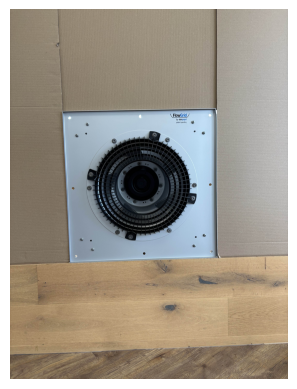

In [10]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import cv2
import matplotlib.pyplot as plt

Tk().withdraw()  # Hide the root window
filename = askopenfilename(title="Select an image file")
print("Selected:", filename)

image = cv2.imread(filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [1]:
import cv2
import numpy as np

# Load dictionary and parameters for ArUco
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
parameters = cv2.aruco.DetectorParameters()

# Start webcam
cap = cv2.VideoCapture(0)
marker_length = 0.05  # meters (5 cm)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect markers
    corners, ids, rejected = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=parameters)
    if ids is not None:
        # Draw markers
        cv2.aruco.drawDetectedMarkers(frame, corners, ids)

        # Estimate pose of each marker
        # (Use default camera matrix if not calibrated)
        camera_matrix = np.array([[800, 0, frame.shape[1]/2],
                                  [0, 800, frame.shape[0]/2],
                                  [0, 0, 1]])
        dist_coeffs = np.zeros((4,1))

        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, camera_matrix, dist_coeffs)
        for rvec, tvec in zip(rvecs, tvecs):
            cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, rvec, tvec, 0.05)

        # You can measure distance between two detected markers:
        if len(tvecs) >= 2:
            p1, p2 = tvecs[0][0], tvecs[1][0]
            distance = np.linalg.norm(p1 - p2)
            cv2.putText(frame, f"Distance: {distance*100:.1f} cm", (30, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    cv2.imshow("AR Measurement", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


OpenCV: not authorized to capture video (status 0), requesting...
OpenCV: camera failed to properly initialize!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files

# --- Upload photo ---
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]

# --- Read image ---
image = cv2.imread(image_filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- Find red pixels (assumes you marked exactly 4 corners in red) ---
mask = (image[:, :, 2] > 200) & (image[:, :, 1] < 50) & (image[:, :, 0] < 50)
points = np.argwhere(mask)  # gives (y, x)

if len(points) != 4:
    raise ValueError(f"Expected 4 red points, found {len(points)}")

# Sort points roughly in top-left, top-right, bottom-right, bottom-left order
# We'll sort by y first (top vs bottom), then x
points = sorted(points, key=lambda p: (p[0], p[1]))
top = sorted(points[:2], key=lambda p: p[1])      # top-left, top-right
bottom = sorted(points[2:], key=lambda p: p[1])   # bottom-left, bottom-right
pts_src = np.array([top[0][::-1], top[1][::-1], bottom[1][::-1], bottom[0][::-1]], dtype=np.float32)
# [::-1] converts (y, x) → (x, y) for OpenCV

# --- Define destination points (perfect square, 10x10 cm scaled arbitrarily to pixels) ---
size_px = 500  # output square image in pixels
pts_dst = np.array([
    [0, 0],
    [size_px, 0],
    [size_px, size_px],
    [0, size_px]
], dtype=np.float32)

# --- Compute homography and warp image ---
H, _ = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(image_rgb, H, (size_px, size_px))

# --- Show original and warped images ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.scatter([p[1] for p in points], [p[0] for p in points], c='red', s=80, label='Marked Points')
plt.title("Original Image with Red Points")
plt.legend()

plt.subplot(1,2,2)
plt.imshow(warped)
plt.title("Warped Image (Perfect Square)")

plt.show()


ModuleNotFoundError: No module named 'google.colab'

In [3]:
import ipywidgets as widgets
from IPython.display import display
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def on_upload_change(change):
    for name, file_info in uploader.value.items():
        img = Image.open(BytesIO(file_info['content']))
        img_np = np.array(img)
        plt.imshow(img_np)
        plt.axis('off')
        plt.show()

uploader.observe(on_upload_change, names='value')


ModuleNotFoundError: No module named 'ipywidgets'

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- Step 1: Load image manually ---
# Replace with your local image path
image_path = "//Users/jiangnan/Study/FUN/projects_ongoing/FanVision_3D_IDS_Hackathon/others/with red dots.jpg"  # <-- change this

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at: {image_path}")

# --- Step 2: Read and convert image ---
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- Step 3: Find red pixels (assumes exactly 4 red corners are marked) ---
mask = (image[:, :, 2] > 200) & (image[:, :, 1] < 50) & (image[:, :, 0] < 50)
points = np.argwhere(mask)  # (y, x)

if len(points) != 4:
    raise ValueError(f"Expected 4 red points, found {len(points)}")

# --- Step 4: Sort points (top-left, top-right, bottom-right, bottom-left) ---
points = sorted(points, key=lambda p: (p[0], p[1]))
top = sorted(points[:2], key=lambda p: p[1])      # top-left, top-right
bottom = sorted(points[2:], key=lambda p: p[1])   # bottom-left, bottom-right
pts_src = np.array([top[0][::-1], top[1][::-1], bottom[1][::-1], bottom[0][::-1]], dtype=np.float32)

# --- Step 5: Define destination points (square output) ---
size_px = 500  # size of the output image
pts_dst = np.array([
    [0, 0],
    [size_px, 0],
    [size_px, size_px],
    [0, size_px]
], dtype=np.float32)

# --- Step 6: Compute homography and warp image ---
H, _ = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(image_rgb, H, (size_px, size_px))

# --- Step 7: Visualize results ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.scatter([p[1] for p in points], [p[0] for p in points], c='red', s=80, label='Marked Points')
plt.title("Original Image with Red Points")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title("Warped Image (Perfect Square)")

plt.show()


ValueError: Expected 4 red points, found 1600

In [ ]:
import cv2
import numpy as np

# --- Parameters ---
# Provide the known width (in cm) of the reference object (e.g., a card, coin)
KNOWN_WIDTH = 8.56  # Example: credit card width = 8.56 cm

# --- Load Image ---
image_path = "/Users/jiangnan/Study/FUN/projects_ongoing/FanVision_3D_IDS_Hackathon/others/with red dots.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# --- Edge detection and contours ---
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# --- Helper function: midpoint ---
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

pixels_per_metric = None

for c in cnts:
    if cv2.contourArea(c) < 100:
        continue

    # Compute rotated bounding box
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    # Order the points
    box = sorted(box, key=lambda x: (x[1], x[0]))
    top_two = sorted(box[:2], key=lambda x: x[0])
    bottom_two = sorted(box[2:], key=lambda x: x[0])
    ordered_box = np.array([top_two[0], top_two[1], bottom_two[1], bottom_two[0]])

    (tl, tr, br, bl) = ordered_box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # Compute distances between midpoints
    dA = np.sqrt((tltrX - blbrX) ** 2 + (tltrY - blbrY) ** 2)
    dB = np.sqrt((tlblX - trbrX) ** 2 + (tlblY - trbrY) ** 2)

    # Initialize pixels_per_metric using the reference object (first contour)
    if pixels_per_metric is None:
        pixels_per_metric = dB / KNOWN_WIDTH
        ref_box = ordered_box
        continue

    # Compute dimensions
    dimA = dA / pixels_per_metric
    dimB = dB / pixels_per_metric

    cv2.drawContours(image, [ordered_box.astype("int")], -1, (0, 255, 0), 2)
    cv2.putText(image, f"W: {dimB:.2f}cm", (int(tl[0]), int(tl[1]) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(image, f"H: {dimA:.2f}cm", (int(tl[0]), int(tl[1]) - 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# --- Show result ---
cv2.imshow("Measured Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


2025-10-08 18:24:20.121 Python[96051:27646811] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


: 